In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# Function for converting series data to a supervised data of format, t-1, t, t+1
## Basically feeding in the (t-1)th data to predict the t data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [3]:
 
# load dataset
dataset = read_csv('normalized_tva_server_1_tactic_1_train.csv')
dataset= dataset.drop(columns=["ID"])
values = dataset.values
print(dataset.head(5))
## Load Validation
validation = read_csv('normalized_tva_server_1_tactic_1_test.csv')
validation= validation.drop(columns=["ID"])
values_validation = validation.values


      Hours   Minutes   Seconds   Latency      Cost  Reliability
0  0.695652  0.576271  0.758364  0.015102  0.193359            1
1  0.695652  0.644068  0.861176  0.015117  0.310547            1
2  0.695652  0.661017  0.854314  0.015297  0.169922            1
3  0.695652  0.728814  0.320405  0.014803  0.191406            1
4  0.695652  0.796610  0.353964  0.014817  0.167969            1


In [4]:
## Calling the function to do the preprocessing the data and removing unwanted columns


# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
reframed_validation = series_to_supervised(values_validation, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8]], axis=1, inplace=True)
reframed_validation.drop(reframed_validation.columns[[6,7,8]], axis=1, inplace=True)
print(reframed.head(1))

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var4(t)  \
1   0.695652   0.576271   0.758364   0.015102   0.193359        1.0  0.015117   

    var5(t)  var6(t)  
1  0.310547      1.0  


In [5]:
## Splitting the data into training and validation sets


train = reframed.values
test = reframed_validation.values
# split into input and outputs
train_X, train_y = train[:, :-3], train[:,-3:]
test_X, test_y = test[:, :-3], test[:,-3:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(12156, 1, 6) (12156, 3) (2604, 1, 6) (2604, 3)


Train on 12156 samples, validate on 2604 samples
Epoch 1/20
12156/12156 [==============================] - 8s 671us/step - loss: 0.0216 - val_loss: 0.0013
Epoch 2/20
12156/12156 [==============================] - 7s 591us/step - loss: 2.8782e-04 - val_loss: 1.2886e-04
Epoch 3/20
12156/12156 [==============================] - 7s 592us/step - loss: 8.5222e-05 - val_loss: 1.8440e-04
Epoch 4/20
12156/12156 [==============================] - 7s 592us/step - loss: 8.9989e-05 - val_loss: 1.3653e-04
Epoch 5/20
12156/12156 [==============================] - 7s 594us/step - loss: 9.5630e-05 - val_loss: 1.2367e-04
Epoch 6/20
12156/12156 [==============================] - 7s 596us/step - loss: 7.8376e-05 - val_loss: 9.5372e-05
Epoch 7/20
12156/12156 [==============================] - 7s 597us/step - loss: 7.8204e-05 - val_loss: 1.1827e-04
Epoch 8/20
12156/12156 [==============================] - 7s 599us/step - loss: 8.9796e-05 - val_loss: 1.0323e-04
Epoch 9/20
12156/12156 [=======================

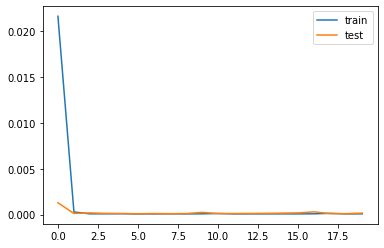

In [6]:
# design LSTM network  has 1000 hidden layers , used adam optimizer and mse loss function
model = Sequential()
model.add(LSTM(1000, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(3))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [7]:
### Doing the same process for testing dataset

test_dataset = read_csv('normalized_tva_server_1_tactic_1_validation.csv')
test_dataset= test_dataset.drop(columns=["ID"])
test_values = test_dataset.values
reframed_test = series_to_supervised(test_values, 1, 1)
reframed_test.drop(reframed_test.columns[[6,7,8]], axis=1, inplace=True)
testset = reframed_test.values
testset_X, testset_y = testset[:, :-3], testset[:,-3:]
testdataReshaped = testset_X.reshape((testset_X.shape[0], 1, testset_X.shape[1]))
print(testset_X.shape, testset_X.shape)

(2605, 6) (2605, 6)


In [8]:
## Feeding the test dataset for predictions
import pandas as pd

yhat = model.predict(testdataReshaped)

print(yhat)
dataset = pd.DataFrame({'predicted_Latency': yhat[:, 0], 'predicted_Cost': yhat[:, 1],
                       'predicted_Reliability': yhat[:, 2]})
dataset['predicted_Reliability'].loc[dataset['predicted_Reliability'] >0.5] = 1
dataset['predicted_Reliability'].loc[dataset['predicted_Reliability'] <0.5] = 0

[[0.01676587 0.18766816 1.003421  ]
 [0.01644325 0.18836051 1.0042111 ]
 [0.0161974  0.18838459 1.0040728 ]
 ...
 [0.0169197  0.18907693 1.0151429 ]
 [0.01682715 0.18826535 1.0135691 ]
 [0.01716219 0.18747202 1.0126711 ]]


In [9]:
frames = [test_dataset, dataset]
result = pd.concat(frames,axis =1)

In [10]:
import numpy as np
result.head(10)
result.to_csv('/Users/manali/JupyterProjects/predictions_LSTM_Server_1_Tactic_1.csv', sep=',', index=0)

In [11]:
print(testset_y)

[[0.0149483  0.16796875 1.        ]
 [0.01529248 0.1640625  1.        ]
 [0.0162831  0.16992188 1.        ]
 ...
 [0.01635488 0.1796875  1.        ]
 [0.01666088 0.17382812 1.        ]
 [0.01505033 0.16601562 1.        ]]


In [12]:
## Finding the root mean squared error of the model
import numpy as np

rmse = np.sqrt(mean_squared_error(yhat, testset_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.047
